# ECA用

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline
import sweetviz as sv
sv.config_parser.read('../sweetviz_settings/sweetviz_settings.ini')
# sv.config_parser.read('sweetviz_setting.ini')
import category_encoders as ce
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error




pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('train shape', train.shape)
print('test shape' , test.shape)
train

train shape (207, 12)
test shape (40, 11)


,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2013-11-18,90,月,0,厚切りイカフライ,NaN,NaN,NaN,NaN,快晴,--,19.8
1,2013-11-19,101,火,1,手作りヒレカツ,NaN,NaN,NaN,NaN,快晴,--,17.0
2,2013-11-20,118,水,0,白身魚唐揚げ野菜あん,NaN,NaN,NaN,NaN,快晴,--,15.5
3,2013-11-21,120,木,1,若鶏ピリ辛焼,NaN,NaN,NaN,NaN,快晴,--,15.2
4,2013-11-22,130,金,1,ビッグメンチカツ,NaN,NaN,NaN,NaN,快晴,--,16.1
...,...,...,...,...,...,...,...,...,...,...,...,...
202,2014-9-24,59,水,1,白身魚のマスタード焼き,408.0,NaN,NaN,NaN,曇,0,24.8
203,2014-9-25,50,木,0,牛カルビ焼き肉,394.0,NaN,NaN,NaN,曇,0,25.4
204,2014-9-26,45,金,0,ランチビュッフェ,NaN,スペシャルメニュー（800円）,キャリアアップ支援セミナー,NaN,晴れ,--,27.1
205,2014-9-29,56,月,1,豚肉と玉子の炒め,404.0,NaN,NaN,NaN,快晴,--,26.6


In [7]:
test

,datetime,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2014-10-1,水,1,メンチカツ,420.0,NaN,NaN,NaN,雨,0,20.2
1,2014-10-2,木,0,バーベキューチキン,415.0,NaN,NaN,NaN,曇,--,23.9
2,2014-10-3,金,0,豚肉のマスタード焼き,405.0,NaN,NaN,NaN,晴れ,--,28.7
3,2014-10-6,月,1,麻婆春雨,400.0,NaN,NaN,NaN,雨,0.5,21.5
4,2014-10-7,火,0,厚揚げ肉みそ炒め,430.0,NaN,NaN,NaN,晴れ,--,22.1
...,...,...,...,...,...,...,...,...,...,...,...
35,2014-11-21,金,0,ロコモコ丼,NaN,お楽しみメニュー,NaN,NaN,快晴,--,14.9
36,2014-11-25,火,1,なすと挽肉のはさみ揚げ,460.0,NaN,NaN,NaN,雨,1.5,11.4
37,2014-11-26,水,1,鶏肉の治部煮風,415.0,NaN,NaN,NaN,雨,1,9.2
38,2014-11-27,木,0,牛丼風,420.0,NaN,NaN,NaN,快晴,--,15.1


In [ ]:
train[]

# 元データの確認

nan値があると、分析からはずされる？ようなので、カテゴリ系のnan値は他の値に一旦いれておく

In [64]:
train_cp = train.copy()
test_cp = test.copy()

train_cp['remarks'].fillna('0', inplace = True)
train_cp['event'].fillna('0', inplace = True)
train_cp['payday'].fillna(0, inplace = True)
test_cp['remarks'].fillna('0', inplace = True)
test_cp['event'].fillna('0', inplace = True)
test_cp['payday'].fillna(0, inplace = True)

In [65]:
my_report = sv.compare([train_cp, 'Train'], [test_cp, 'Test'], 'y')
my_report.show_html('sweetviz_report/sweetviz_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report/sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



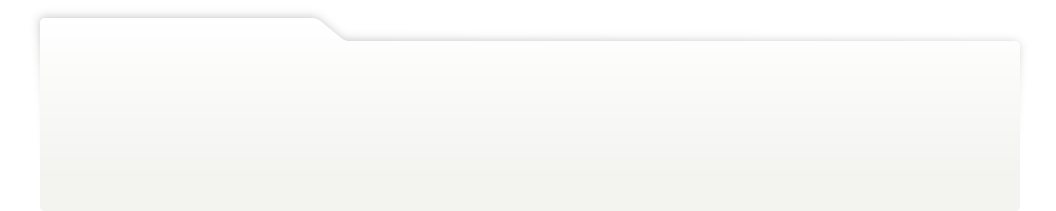
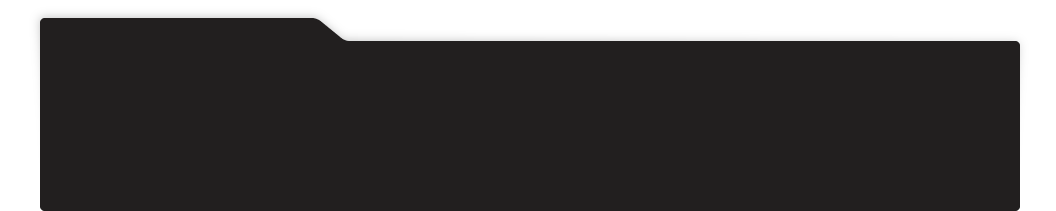
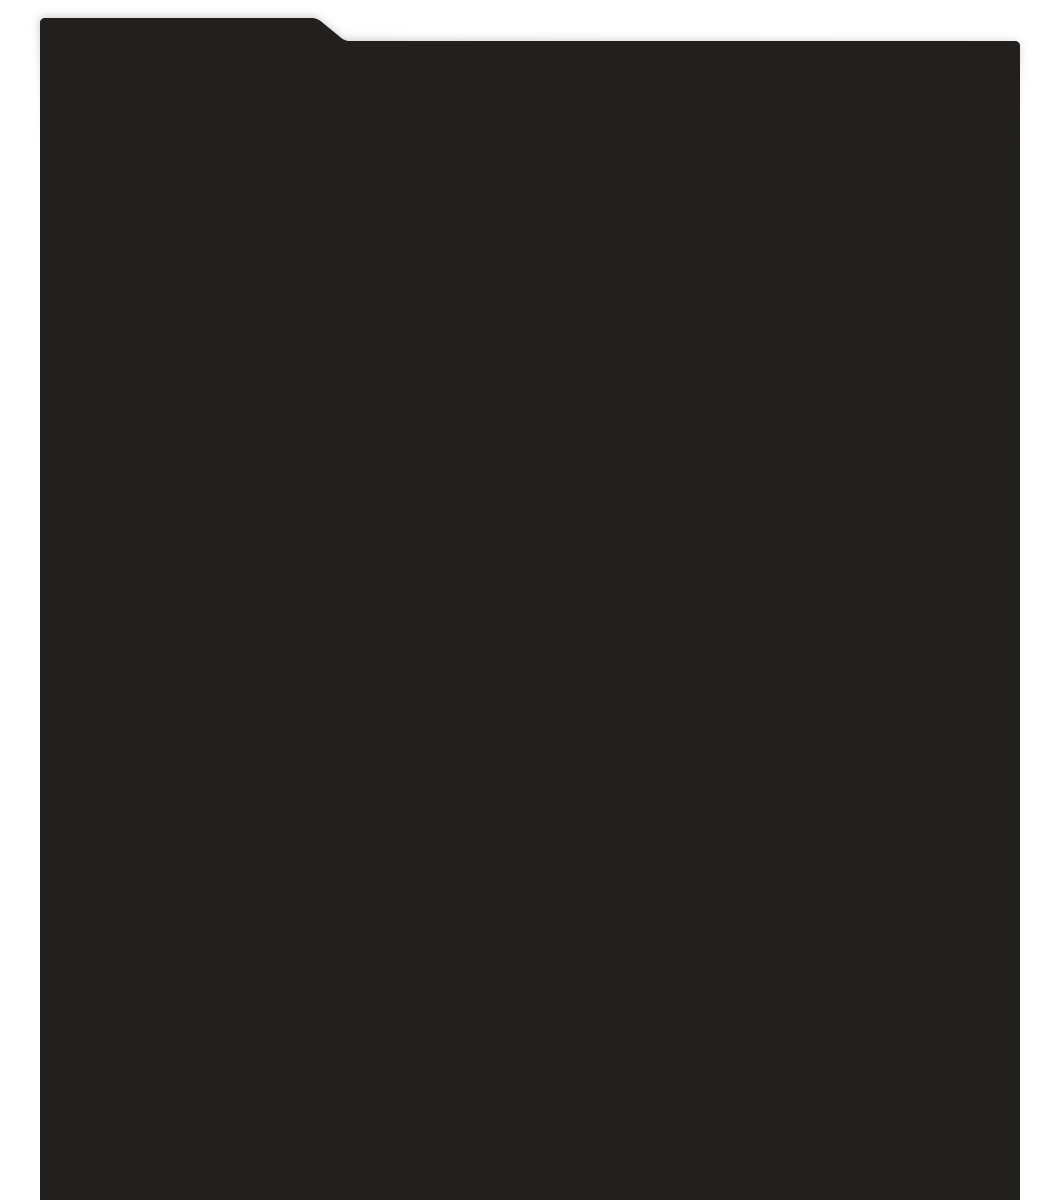
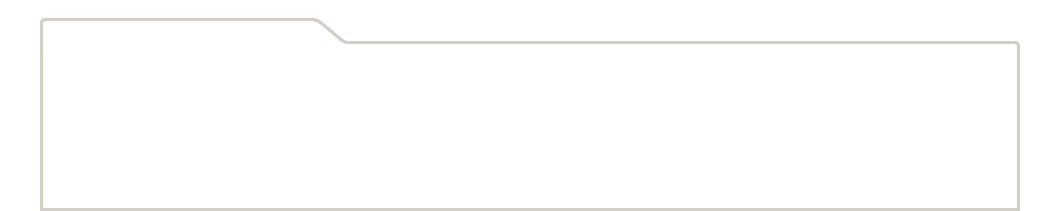
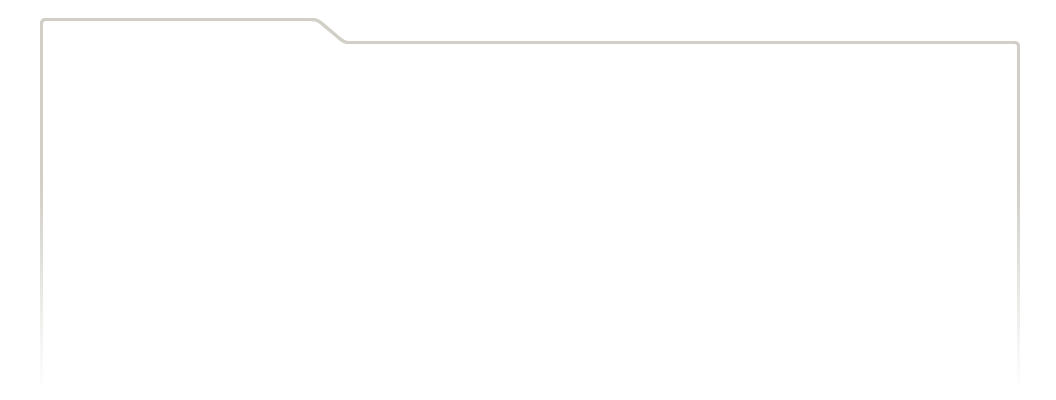
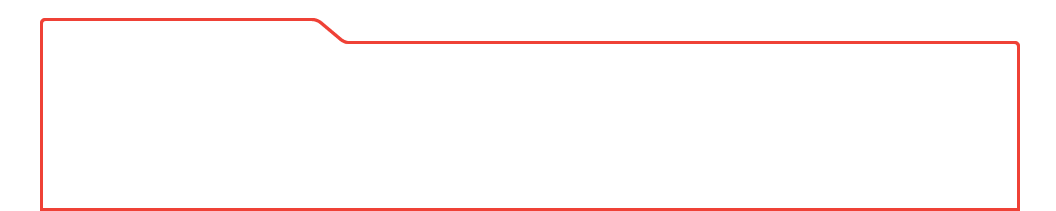
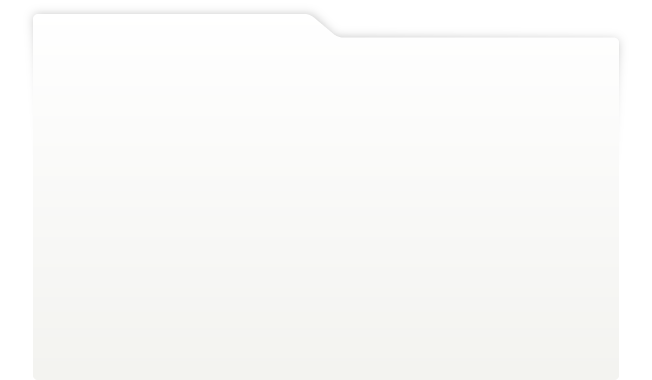
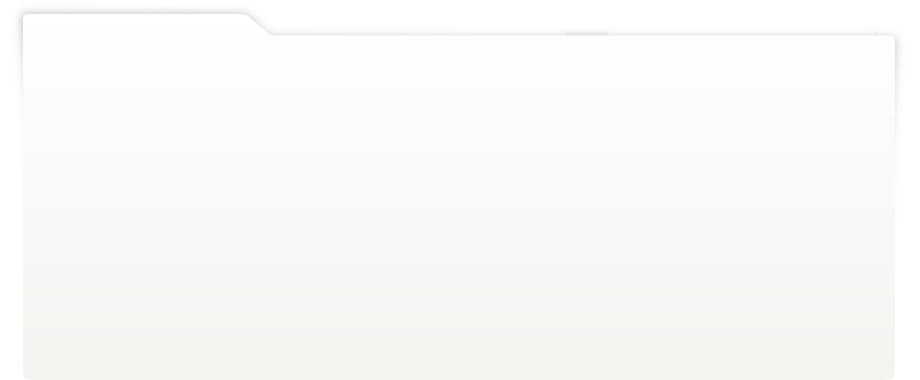
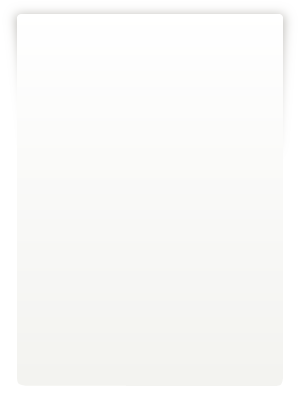
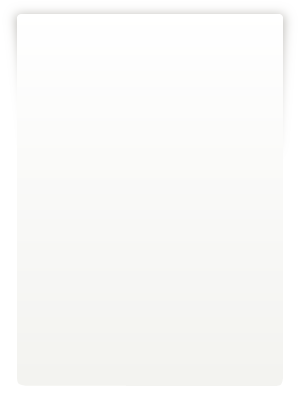
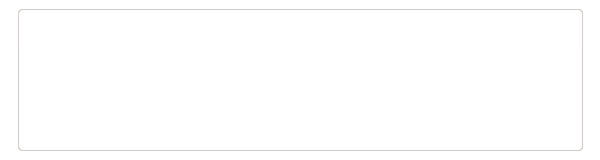
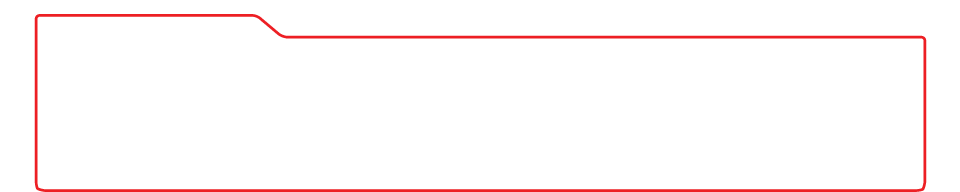
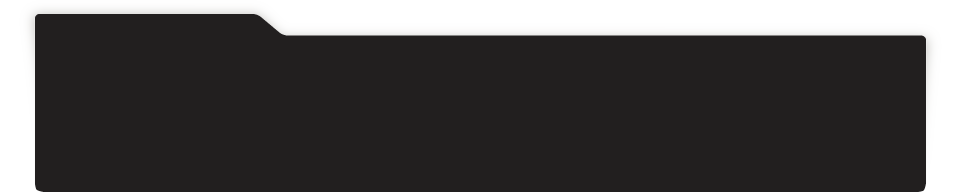
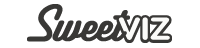
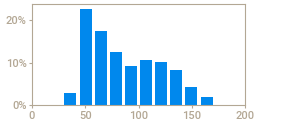
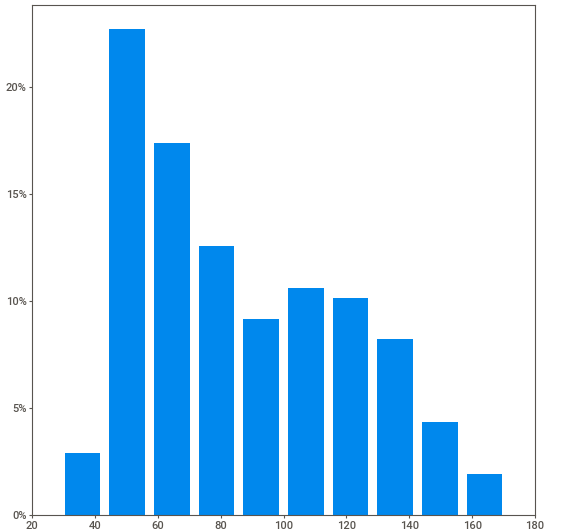
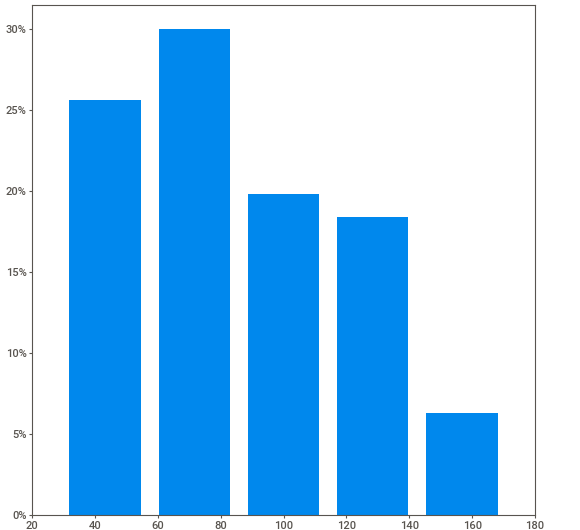
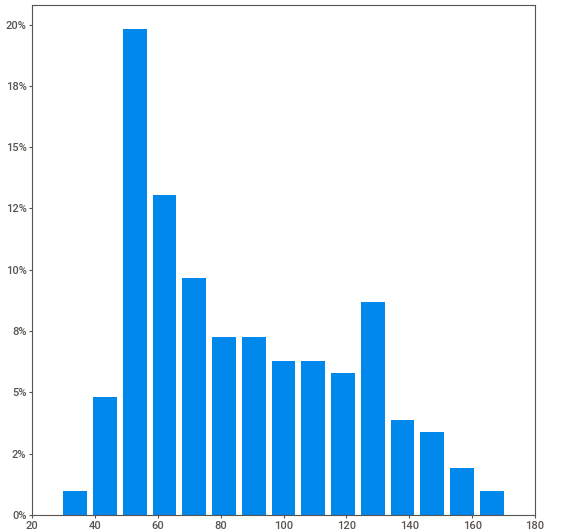
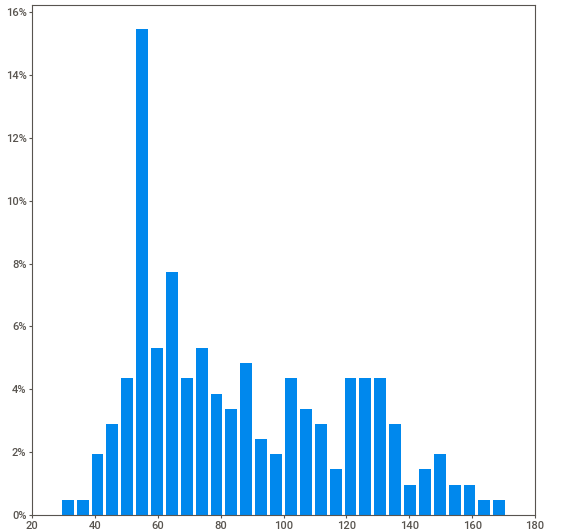
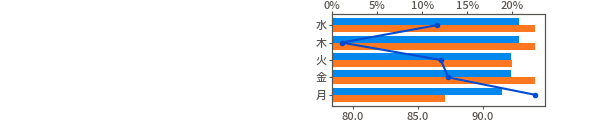
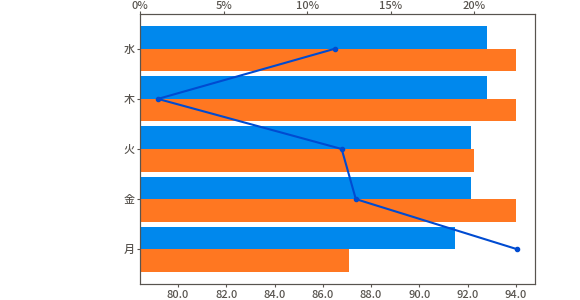
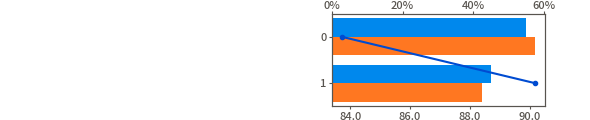
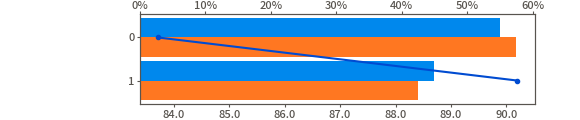
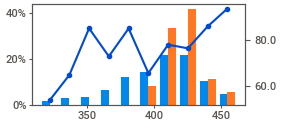
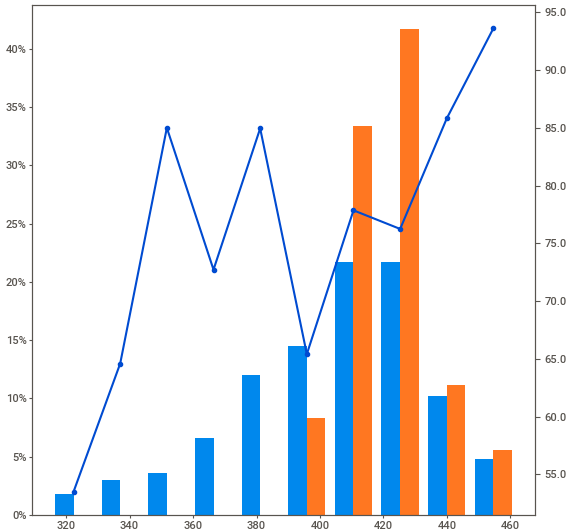
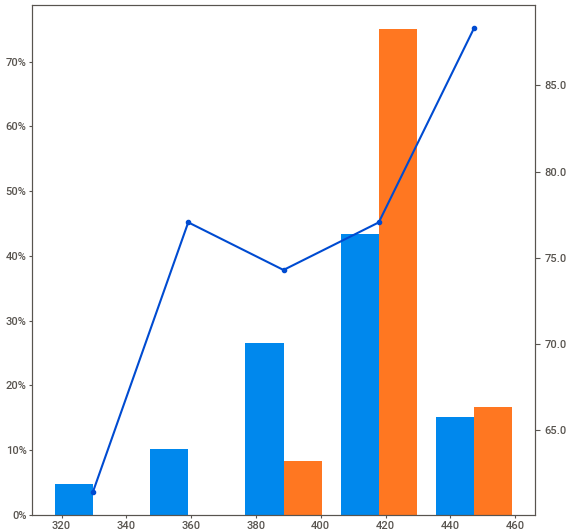
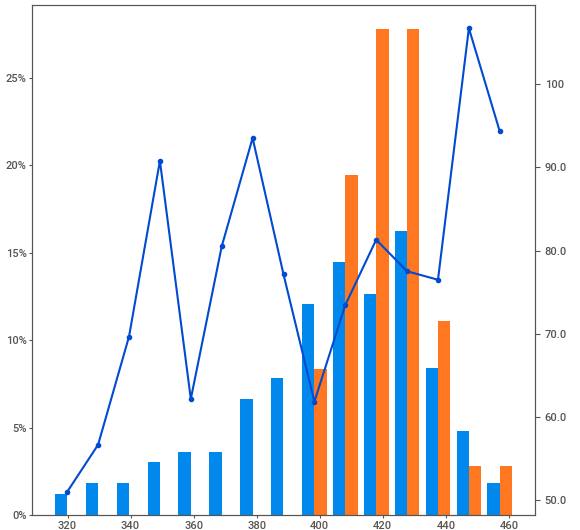
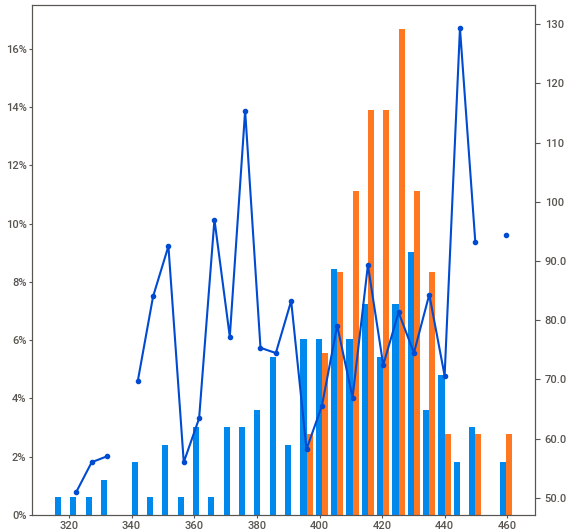
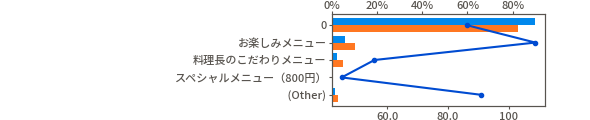
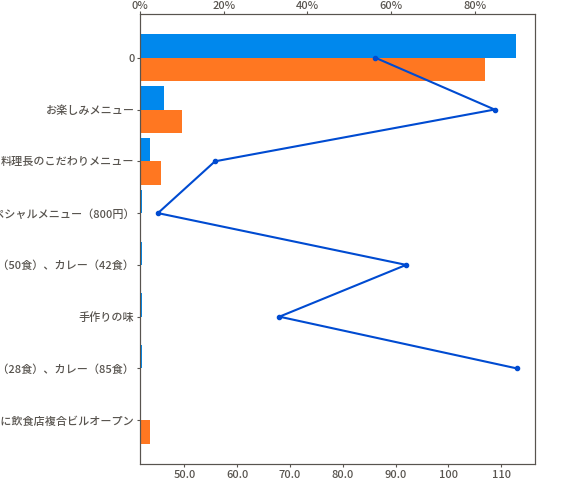
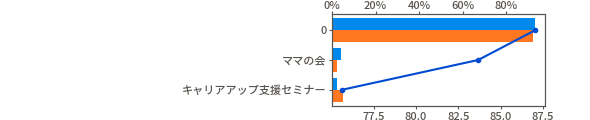
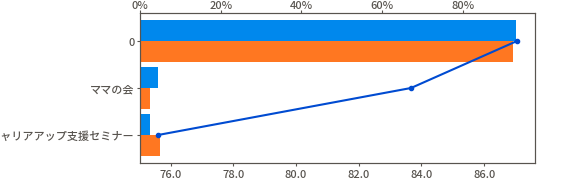
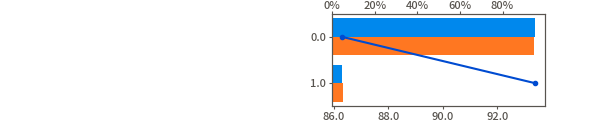
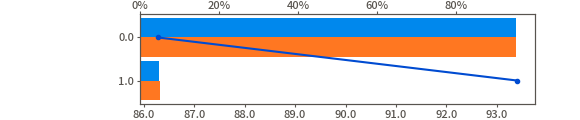
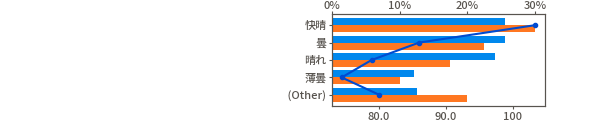
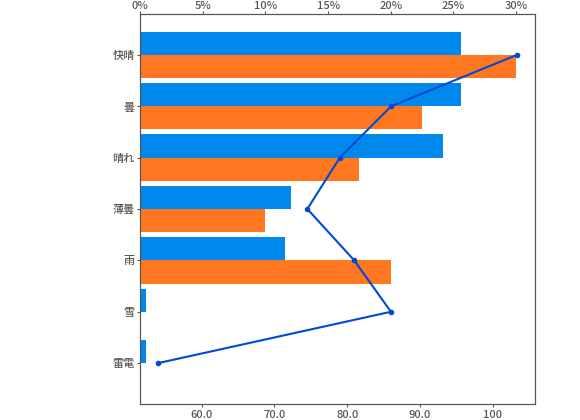
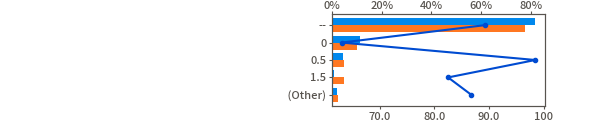
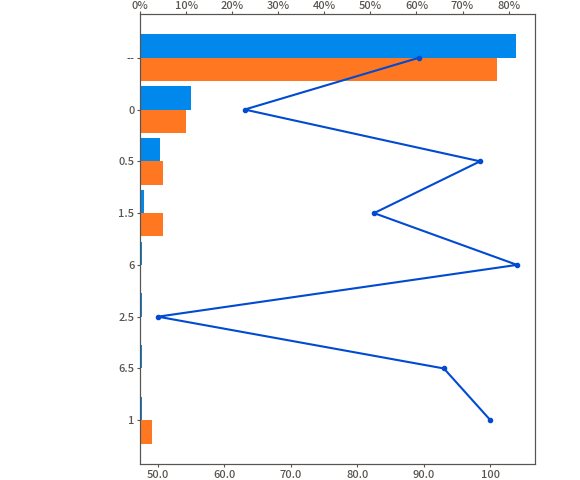
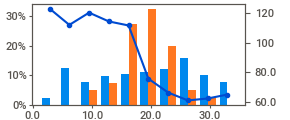
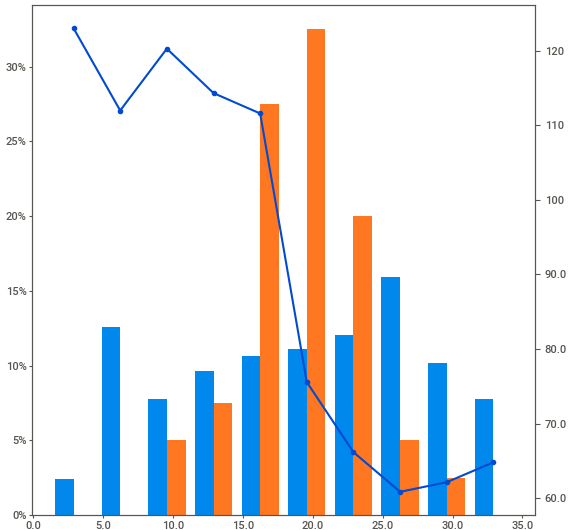
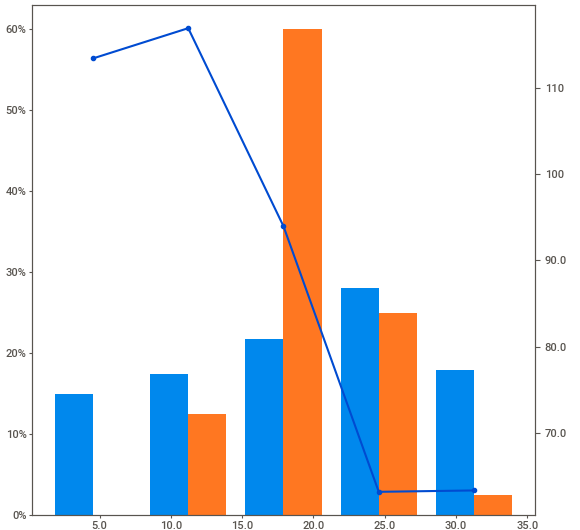
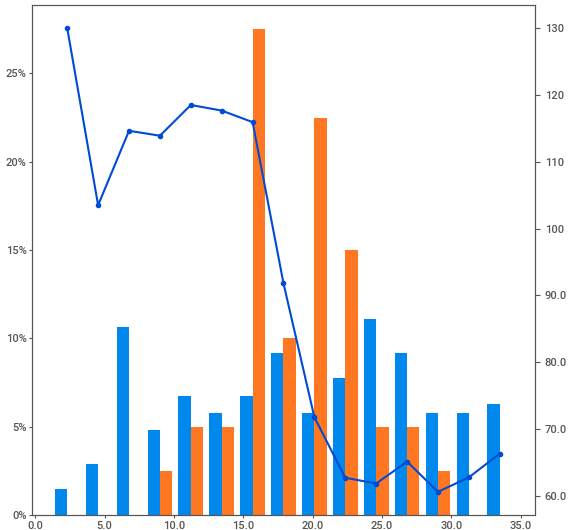
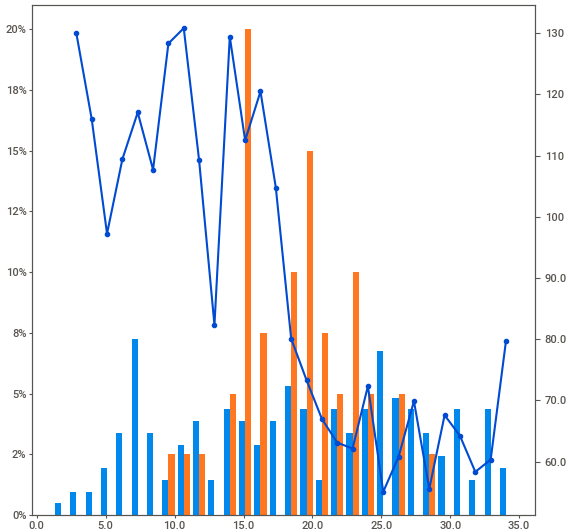
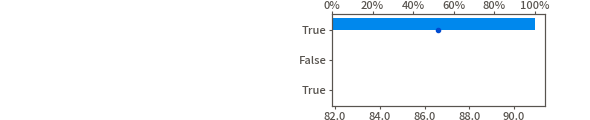
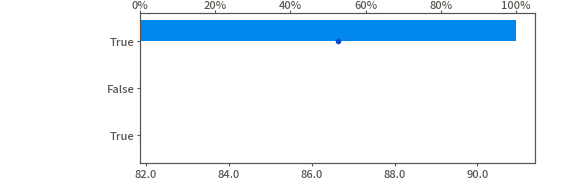
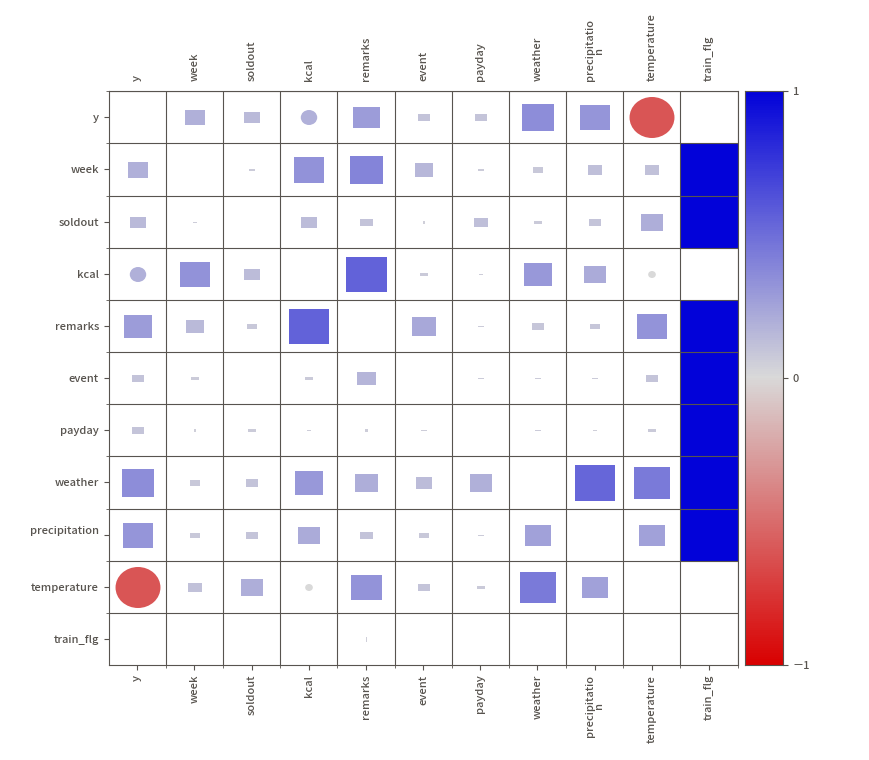
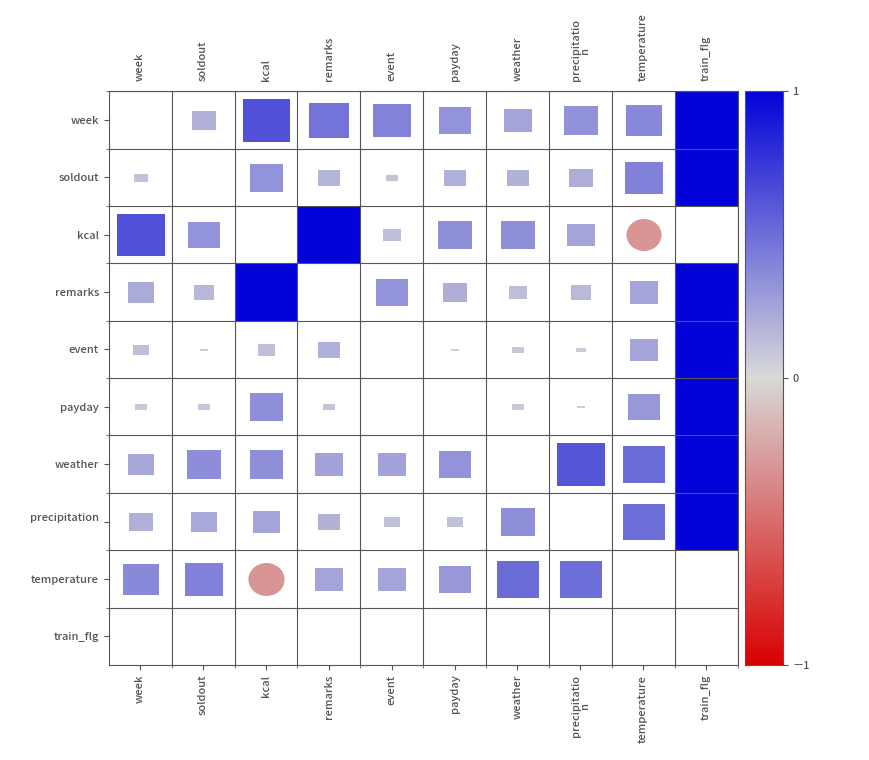

In [66]:
my_report.show_notebook()

## datetime
* train : １１月〜翌年９月
* test  : 翌年10月〜１１月のみ
→ trainは１年弱のデータだが、ｔestは秋ごろの１ヶ月ちょっとしかない  
→ 気温とか、天気に偏りがあるかもしれない。

## week
* testデータは月曜日が少ない  
(木    43  
 水    43  
 金    41  
 火    41  
 月    39  
 Name: week, dtype: int64,  
 木    9  
 水    9  
 金    9  
 火    8  
 月    5  
 Name: week, dtype: int64)  

## soldout
* 売り切れていない日の方が多い。  
* soldout 1と０の比率は、testとtrainで大きく変わらない  
→ 特徴量としてそのまま使えそう

## kcal
* trainとtestでkcalの幅、中央値が違う。  
* どちらも欠損値があるが、trainの方が欠損値が多い  
→kcalの欠損をどう埋めるか？

## remarks
* train側にしかない情報がある　（スペシャルメニュー、○食カレーみたいなやつ、手作りの味）
* test側にしかない情報がある（近場にビルオープン）  
→train側、test側にしかない情報はそれぞれ１件しかないのでノイズと思われる。　削除した方がよさそう

## event
* ママの会、キャリアアップセミナ　の二種しかない
* ｔrainは１４回イベント、testは３回イベント
* trainはママの会が９回、testは２回 、 キャリアが（５回、１回）  
→　データが少し少ないけど、使えそう？

## payday
* 給料日のデータ数が少ないのでわかりにくいが、給料日の方がお弁当買う人が多い  
給料日だったらむしろ、お弁当じゃなくて外食で減りそうな気もするが・・  
月ごとの平均と給料日を比較して行った方がよさそう・・？

## weather
* 雪と雷電はtrainにしかなく、数もすくない  
→ 雨とかに丸め込んだ方がよさそう  
→ 曇と薄曇に差異があるか？　確認したほうがよい。  
→ 晴と快晴に差異があるか？　確認したほうがよい。  

train  
快晴    65  
曇     62  
晴れ    57  
雨     32  
薄曇    29  
雪      1  
雷電     1  

test  
快晴    12  
曇      9  
雨      8  
晴れ     7  
薄曇     4  

## precipitation
* train　test どちらも晴れの割合が多い
* 降水量がtrainにしかないものがある。  
→ 雨量の分類は細かすぎるかも。　雨０、　雨小、　雨大みたいに分類するのを試してもいいかも

## 

In [45]:
# trainとtestの識別列を追加
train['train_flg'] = True
test['train_flg'] = False

# データの結合
all_data = pd.concat([train, test], axis = 0)

# weather

In [12]:
train['weather'].value_counts()

快晴    53
曇     53
晴れ    50
薄曇    25
雨     24
雪      1
雷電     1
Name: weather, dtype: int64

In [15]:
test['weather'].value_counts()

快晴    12
曇      9
雨      8
晴れ     7
薄曇     4
Name: weather, dtype: int64

## 雪と雷電の処理
trainに１個ずつしかないこれらの処理方法を考える。

### 雪
雪はtrainにしかなくて、１回しか出現しない。  
雪のときの降水量は０．５ｍｍで、気温は１．２　寒い。    
雨に丸めこむのでよさそう  

前後数日のデータも見てみると、気温はダントツ低いっぽい。

In [17]:
train[train['weather'] == '雪']

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,train_flg
54,2014-2-14,86,金,1,ロース甘味噌焼き,432.0,NaN,NaN,NaN,雪,0.5,1.2,True


In [20]:
train.iloc[34:74]

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,train_flg
34,2014-1-16,107,木,0,カレイ唐揚げ野菜あんかけ,415.0,NaN,NaN,NaN,快晴,--,7.0,True
35,2014-1-17,85,金,1,回鍋肉,430.0,NaN,ママの会,NaN,快晴,--,7.8,True
36,2014-1-20,126,月,1,ジューシーメンチカツ,375.0,NaN,NaN,NaN,晴れ,--,6.5,True
37,2014-1-21,129,火,1,サバ焼味噌掛け,447.0,NaN,NaN,NaN,快晴,--,10.4,True
38,2014-1-22,126,水,1,手作りひれかつとカレー,426.0,NaN,NaN,NaN,快晴,--,7.4,True
39,2014-1-23,107,木,0,酢豚,400.0,NaN,NaN,NaN,快晴,--,8.5,True
40,2014-1-24,92,金,1,鶏のレモンペッパー焼orカレー,418.0,鶏のレモンペッパー焼（50食）、カレー（42食）,NaN,NaN,快晴,--,10.1,True
41,2014-1-27,126,月,1,チンジャオロース,415.0,NaN,NaN,NaN,快晴,--,5.1,True
42,2014-1-28,120,火,0,海老フライタルタル,445.0,NaN,NaN,NaN,快晴,--,12.6,True
43,2014-1-29,121,水,1,チーズ入りメンチカツ,450.0,NaN,NaN,NaN,快晴,--,10.3,True


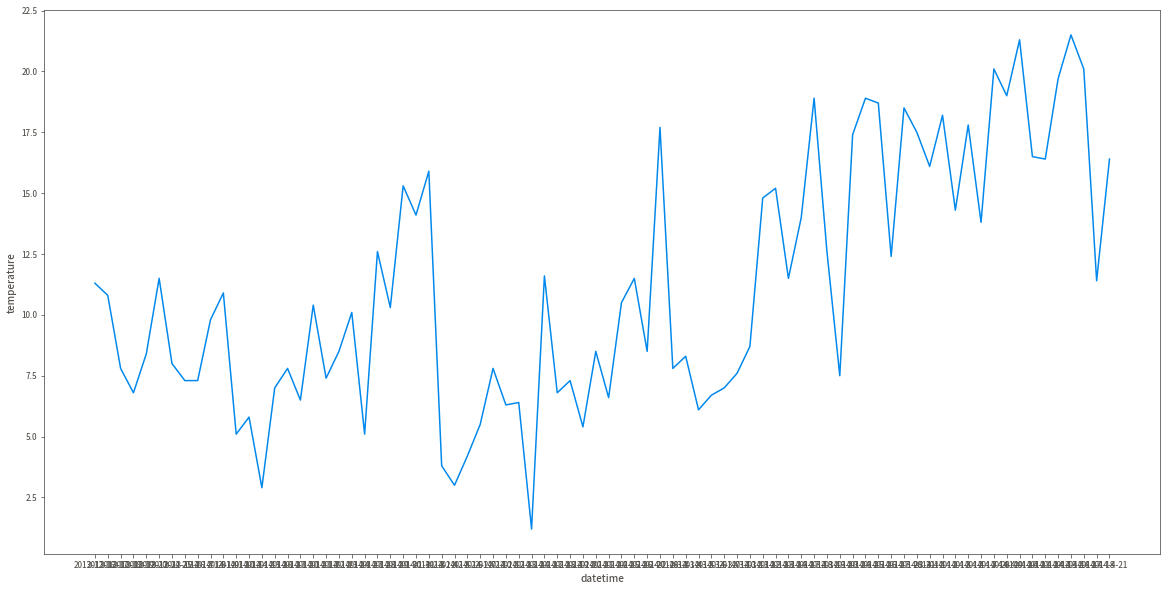

In [27]:
plt.figure(figsize = (20, 10))
sns.lineplot(x = train['datetime'].iloc[20:100], y = train['temperature'].iloc[20:100])
plt.show()

### 雷電
降水量は０．５ｍｍ未満。　５月（梅雨？）で、気温は１９度  
微妙だけど、通常の雨にいれてよさそう  

念のため前後の天気、気温、雨量を見てみる

In [36]:
all_data.loc[all_data['weather'] == '雷電']

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,train_flg
119,2014-5-22,54.0,木,1,サーモンのムニエル2色ソース,428.0,料理長のこだわりメニュー,NaN,NaN,雷電,0,19.0,True


In [40]:
all_data.iloc[119-30:119+30]

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,train_flg
89,2014-4-7,107.0,月,0,青梗菜牛肉炒め,387.0,NaN,NaN,NaN,快晴,--,13.8,True
90,2014-4-8,96.0,火,1,肉団子のシチュー,353.0,NaN,NaN,NaN,快晴,--,20.1,True
91,2014-4-9,88.0,水,1,青椒肉絲,376.0,NaN,NaN,NaN,晴れ,--,19.0,True
92,2014-4-10,87.0,木,0,鶏の唐揚げおろしソース,362.0,NaN,NaN,1.0,晴れ,--,21.3,True
93,2014-4-11,128.0,金,1,チキンカレー,NaN,お楽しみメニュー,NaN,NaN,快晴,--,16.5,True
94,2014-4-14,92.0,月,0,ビーフトマト煮,340.0,NaN,NaN,NaN,晴れ,--,16.4,True
95,2014-4-15,82.0,火,0,ポーク生姜焼き,370.0,NaN,NaN,NaN,快晴,--,19.7,True
96,2014-4-16,57.0,水,0,カレイ唐揚げ野菜あんかけ,330.0,NaN,NaN,NaN,薄曇,--,21.5,True
97,2014-4-17,57.0,木,0,牛丼風煮,333.0,NaN,NaN,NaN,快晴,--,20.1,True
98,2014-4-18,56.0,金,1,鶏の味噌漬け焼き,325.0,NaN,ママの会,NaN,曇,0,11.4,True


# payday
給料日の時とそうじゃないときで販売量に差があるのか？　  
→よくわからん。　なさそうな気がする。

In [78]:
all_data_datetime = all_data.copy()
all_data_datetime['datetime'] = pd.to_datetime(all_data_datetime['datetime'])
all_data_datetime['YM'] = all_data_datetime['datetime'].dt.strftime('%Y%m')
all_data_datetime_YMmean = all_data_datetime.groupby(by = 'YM', as_index = False).mean()

all_data_datetime_YMmean_vs_payday = all_data_datetime_YMmean.merge(all_data_datetime[['y', 'YM']].loc[all_data_datetime['payday'] == 1], on = 'YM')
all_data_datetime_YMmean_vs_payday

,YM,y_x,soldout,kcal,payday,temperature,train_flg,y_y
0,201312,139.722222,0.444444,NaN,1.0,10.844444,True,155.0
1,201401,115.222222,0.611111,427.555556,1.0,8.716667,True,87.0
2,201402,107.842105,0.526316,420.947368,1.0,7.815789,True,137.0
3,201403,89.350000,0.450000,382.157895,1.0,12.505000,True,123.0
4,201404,85.761905,0.476190,360.000000,1.0,18.176190,True,87.0
5,201405,74.200000,0.550000,419.111111,1.0,22.505000,True,58.0
6,201406,67.285714,0.333333,423.315789,1.0,25.409524,True,56.0
7,201407,61.363636,0.454545,397.200000,1.0,29.350000,True,48.0
8,201408,61.166667,0.333333,403.187500,1.0,30.227778,True,129.0
9,201409,55.550000,0.300000,408.611111,1.0,25.935000,True,54.0


<AxesSubplot:xlabel='YM', ylabel='y_x'>

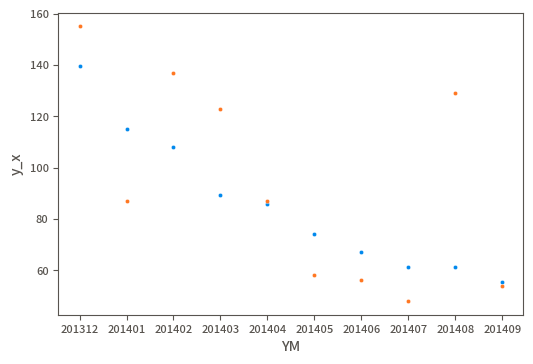

In [85]:
sns.scatterplot(x = 'YM', y = 'y_x', data = all_data_datetime_YMmean_vs_payday)
sns.scatterplot(x = 'YM', y = 'y_y', data = all_data_datetime_YMmean_vs_payday)


### 販売側の意図　給料日のメニューに偏りはあるか？

In [104]:
all_data.loc[all_data['payday'] == 1]

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,train_flg
16,2013-12-10,155.0,火,0,やわらかロースのサムジョン,NaN,NaN,NaN,1.0,曇,0.5,7.1,True
31,2014-1-10,87.0,金,0,手作りロースカツ,440.0,NaN,NaN,1.0,快晴,--,5.1,True
51,2014-2-10,137.0,月,0,鶏の唐揚げおろしソース,423.0,NaN,NaN,1.0,曇,--,7.8,True
70,2014-3-10,123.0,月,0,海老クリーミ―クノーデル,385.0,NaN,NaN,1.0,曇,--,7.6,True
92,2014-4-10,87.0,木,0,鶏の唐揚げおろしソース,362.0,NaN,NaN,1.0,晴れ,--,21.3,True
110,2014-5-9,58.0,金,1,手作りチキンカツ,434.0,NaN,NaN,1.0,晴れ,--,23.4,True
132,2014-6-10,56.0,火,0,カレイ唐揚げ野菜餡かけ,426.0,NaN,NaN,1.0,曇,--,25.5,True
154,2014-7-10,48.0,木,0,プルコギ,386.0,NaN,NaN,1.0,曇,--,28.8,True
174,2014-8-8,129.0,金,0,チキンカレー,NaN,お楽しみメニュー,NaN,1.0,曇,--,31.1,True
194,2014-9-10,54.0,水,0,ぶりレモンペッパー焼き,450.0,NaN,NaN,1.0,曇,0,25.0,True


# week

## 曜日における販売量

,week
0,0 2013-11-18\n1 2013-11-19\n2 2013...
1,0 2013-11-18\n1 2013-11-19\n2 2013...
2,0 2013-11-18\n1 2013-11-19\n2 2013...
3,0 2013-11-18\n1 2013-11-19\n2 2013...
4,0 2013-11-18\n1 2013-11-19\n2 2013...
...,...
35,0 2013-11-18\n1 2013-11-19\n2 2013...
36,0 2013-11-18\n1 2013-11-19\n2 2013...
37,0 2013-11-18\n1 2013-11-19\n2 2013...
38,0 2013-11-18\n1 2013-11-19\n2 2013...


<AxesSubplot:xlabel='datetime', ylabel='y'>

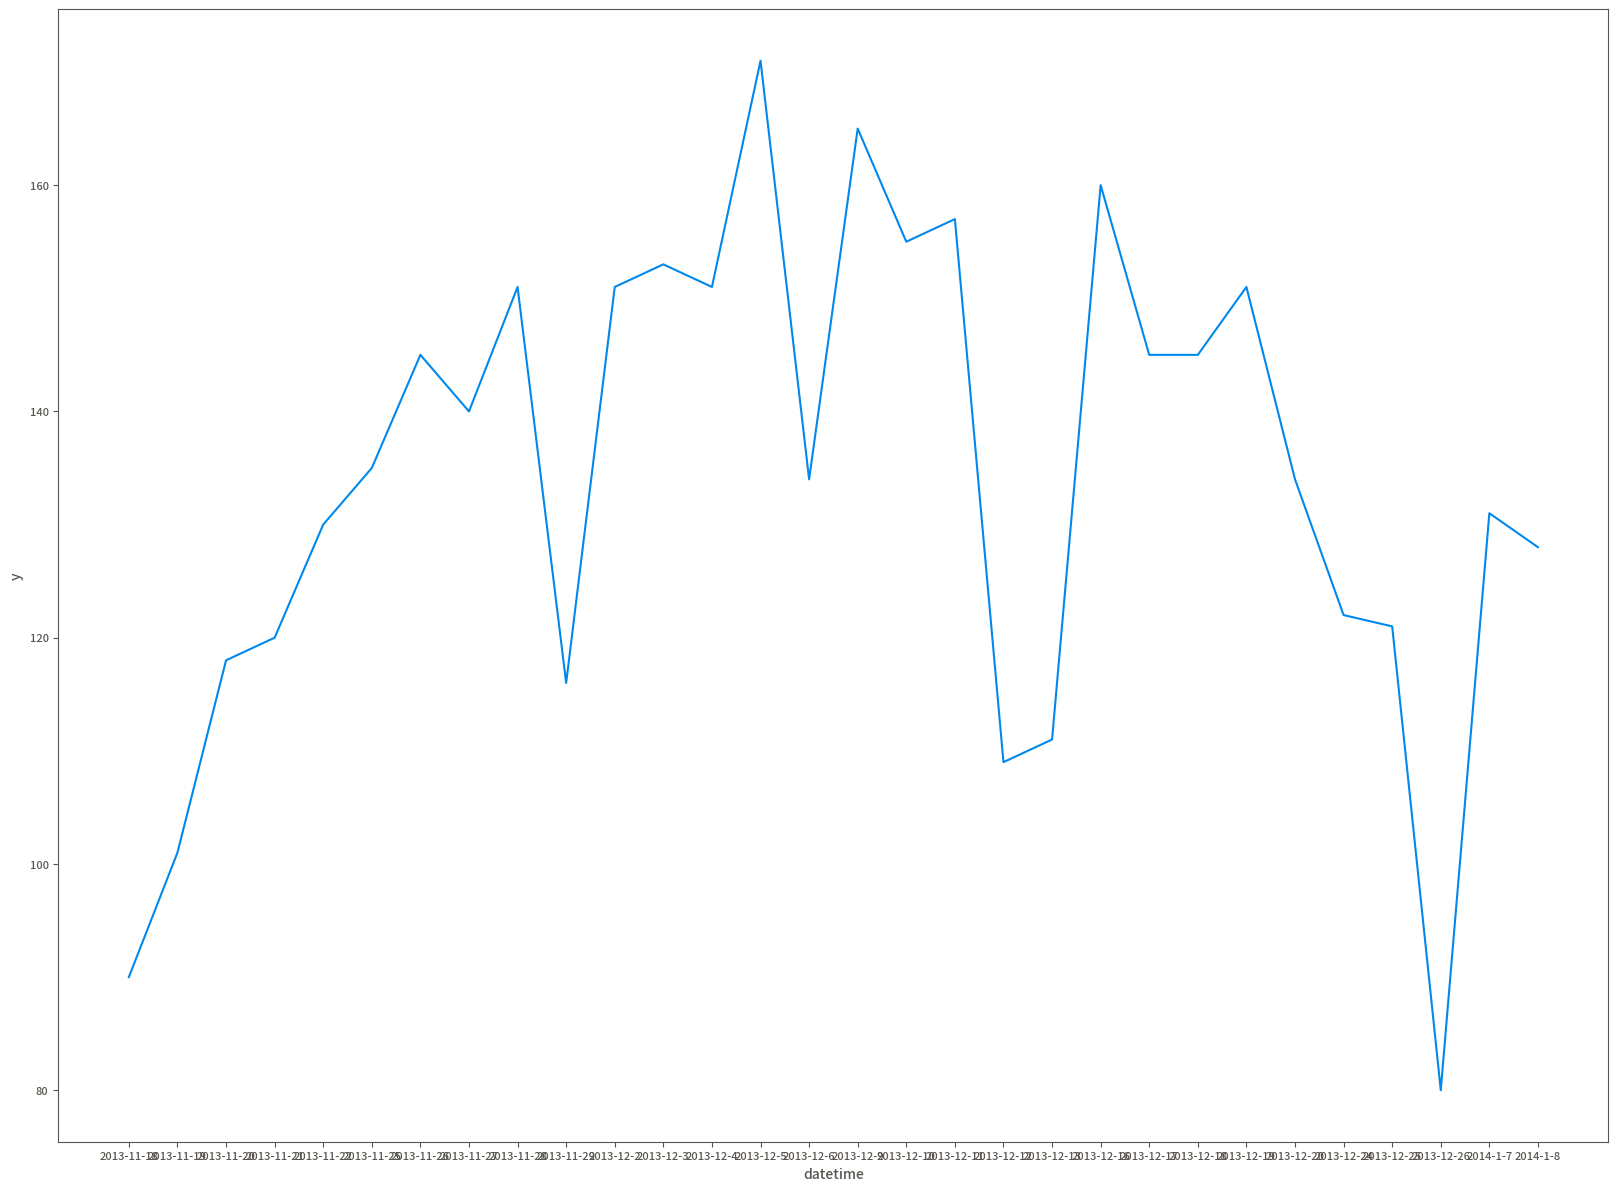

In [112]:
plt.figure(figsize = (20, 15))
sns.lineplot(x = 'datetime', y = 'y', data = all_data.iloc[0:30])

# 関数

In [41]:
### 不要な項目を消す系

# remarksで１個しかないカテゴリは　カテゴリなしにする。
def replace_remarks_cat(df):
    _df = df['remarks'].value_counts().copy()
    _df = _df[_df < 2]
    
    
    for i in _df.index:
        df['remarks'].loc[df['remarks'] == i] = np.nan

# weather 雪と雷電を　雨に置き換え
def replace_weather_cat(df):
    _df = df['weather'].value_counts()
    _df = _df[_df < 2]
    
    for i in _df.index:
        df['weather'].loc[df['weather'] == i] = '雨'

# category_encoding関数
def encoding_func(df, encoding_col_name_list):
    def which_col_is_object_func(df):
        # 列がobjectを抽出してリストに
        keys = list(df.dtypes.loc[df.dtypes == 'object'].index)
        # 辞書化
        values = list(range(len(object_list)))
        object_dic = dict(zip(keys, values))
        print(object_dic)
    
    
    # カテゴリエンコーダーする
    ce_oe = ce.OrdinalEncoder(cols = encoding_col_name_list, handle_unknown = 'impute')
    df = ce_oe.fit_transform(df)

    # カテゴリ番号の確認
    
    for i in range(len(encoding_col_name_list)):
        print(pd.DataFrame(ce_oe.category_mapping[i]))
        print()
    return df


# 休日前flg (category encodingのあとにやる)
def before_holiday_func(df):
    '''
    祝日の次の日にフラグを立てる。
    category encodingのあとに使うこと。
    '''
    df['before_holiday'] = 0
    for i in range(len(df)):
        
        if df['week'].diff(-1).iloc[i] == -1.0:
            df['before_holiday'].iloc[i] = 0        
        
        elif i == len(df):
            df['before_holiday'].iloc[i] = 0
        
        else:
            df['before_holiday'].iloc[i] = 1

            
# 休日後flg (category encodingのあとにやる)
def after_holiday_func(df):
    '''
    祝日の前の日にフラグを立てる。
    category encodingのあとに使うこと。
    '''
    
    df['after_holiday'] = 0

    for i in range(len(df)):
        if i == 1:
            df['week'].iloc[i] == 1
            
        elif df['week'].diff(1).iloc[i] == 1.0:
            df['after_holiday'].iloc[i] = 0
            
        else:
            df['after_holiday'].iloc[i] = 1



In [47]:
replace_weather_cat(all_data)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [115]:
a = all_data['remarks'].value_counts()
del_cat = a[a<2].index



Index(['スペシャルメニュー（800円）', '鶏のレモンペッパー焼（50食）、カレー（42食）', '近隣に飲食店複合ビルオープン',
       '酢豚（28食）、カレー（85食）', '手作りの味'],
      dtype='object')

In [ ]:
def del_category(df):
    _df = df['remarks'].value_counts()
    del_cat = _df[_df > 2].index
    
    del

# 前処理

In [135]:
# trainとtestの識別列を追加
train['train_flg'] = True
test['train_flg'] = False

# データの結合
all_data = pd.concat([train, test], axis = 0)

# NaNの穴埋め
all_data['payday'] = all_data['payday'].fillna(0)
all_data['remarks'] = all_data['remarks'].fillna(0)
all_data['event'] = all_data['event'].fillna(0)

# 降水量の--の処理。
'''
降水量０ｍｍは0.5mm未満のことであるため、雨は降っている。
一方で'--'は雨が降っていない。なので、明確に識別することが必要
ここでは、--を−１に置き換えてみる。
'''

all_data['precipitation'] = all_data['precipitation'].apply(lambda x : -1 if x == '--' else float(x))


# kcalの処理 とりあえず中央値で埋める
all_data['kcal'] = all_data['kcal'].fillna(all_data['kcal'].median())

# メニューの処理
# カレー最強
def is_curry(df):
    df['curry'] = df['name'].apply(lambda x : 1 if 'カレー' in x else 0)
    
all_data['menchikatsu'] = all_data['name'].apply(lambda x : 1 if 'メンチカツ' in x else 0)

### 作った関数を使って前処理していく

# 各種データの変換
all_data['datetime'] = pd.to_datetime(all_data['datetime'])

# encoding
encoding_col_name_list = ['week',
                         'remarks',
                         'event',
                         'weather']

all_data = encoding_func(all_data, encoding_col_name_list)

# 祝日前後の平日にflg
after_holiday_func(all_data)
before_holiday_func(all_data)

# train と testにもどす。
df_train = all_data.loc[all_data['train_flg'] == True]
df_test = all_data.loc[all_data['train_flg'] == False]

/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


      col  mapping data_type
月    week        1    object
火    week        2    object
水    week        3    object
木    week        4    object
金    week        5    object
NaN  week       -2    object

                              col  mapping data_type
0                         remarks        1    object
鶏のレモンペッパー焼（50食）、カレー（42食）  remarks        2    object
酢豚（28食）、カレー（85食）          remarks        3    object
お楽しみメニュー                  remarks        4    object
料理長のこだわりメニュー              remarks        5    object
手作りの味                     remarks        6    object
スペシャルメニュー（800円）           remarks        7    object
近隣に飲食店複合ビルオープン            remarks        8    object
NaN                       remarks       -2    object

                 col  mapping data_type
0              event        1    object
ママの会           event        2    object
キャリアアップ支援セミナー  event        3    object
NaN            event       -2    object

         col  mapping data_type
快晴   weather        1    object
